In [3]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.getcwd())

import trainer
import utils
from missing_util import introduce_mising, preprocessing,introduce_mising_advanced,introduce_mising_middle
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
url1 = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

In [5]:
def preprocessing1(data):
    # ---- drop the classification attribute
    data = data[:, :-1]
    np.random.shuffle(data)
    # ----
    N, D = data.shape
    dl = D - 1
    # ---- standardize data
    data = data - np.mean(data, axis=0)
    data = data / np.std(data, axis=0)

    # ---- random permutation
    p = np.random.permutation(N)
    data = data[p, :]

    Xtrain = data.copy()
    Xval_org = data.copy()

    return data.shape, Xtrain, Xval_org, dl

In [64]:
def random_missing(array, fraction_to_change):
    """
    Randomly changes a fraction of the True values in a boolean array to False.

    Args:
        array (numpy.ndarray): The input boolean array.
        fraction_to_change (float): The fraction of True values to change to False.

    Returns:
        result (numpy.ndarray): The boolean array with the specified fraction of True values changed to False.
    """

    if not np.issubdtype(array.dtype, np.bool_):
        raise ValueError("Input array must be boolean.")

    flat_array = array.flatten()
    n_to_change = int(np.sum(flat_array) * fraction_to_change)
    ix_to_change = np.random.choice(np.flatnonzero(flat_array), size=n_to_change, replace=False)

    result = flat_array.copy()
    result[ix_to_change] = False

    return result.reshape(array.shape)

In [119]:
def random_missing(array, fractions_to_change):
    """
    Randomly changes a fraction of the True values in each column of a boolean array to False.

    Args:
        array (numpy.ndarray): The input boolean array.
        fractions_to_change (list or numpy.ndarray): The fractions of True values to change to False in each column.

    Returns:
        result (numpy.ndarray): The boolean array with the specified fractions of True values changed to False in each column.
    """

    result = array.copy()
    for col in range(result.shape[1]):
        col_array = result[:, col]
        # if need to change to multiple conversion rate
        #n_to_change = int(np.sum(col_array) * fractions_to_change[col])
        n_to_change = int(np.sum(col_array) * fractions_to_change)
        ix_to_change = np.random.choice(np.flatnonzero(col_array), size=n_to_change, replace=False)

        col_array[ix_to_change] = False

    return result

In [98]:
testbl = np.array([[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True],[True,False,True]])

In [100]:
testbl

array([[ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True],
       [ True, False,  True]])

In [105]:
random_missing(testbl,0.5)

array([[ True, False,  True],
       [ True, False, False],
       [False, False, False],
       [False, False, False],
       [False, False,  True],
       [False, False, False],
       [ True, False, False],
       [False, False,  True],
       [ True, False,  True],
       [ True, False,  True]])

In [113]:
def missing_by_quantile(X,missing_quantile = 0.5, missing_dim=0.8, complete_ratio = 0):
    """    
    Missing_quantile: value is larger than quantile will be missing
    Missing_dim: how many columns have missing data
    Missing_ration: if partially or completely missing (default=0, completely missing)
    """

    N, D = X.shape
    Xnan = X.copy()

    # ---- Missing Dimention
    missing_dim = int(missing_dim * D)

    quantile = np.quantile(Xnan[:, :missing_dim],missing_quantile, axis=0)
    
    ix_larger_than_quantile = Xnan[:, :missing_dim] > quantile
    ix_larger_than_quantile = random_missing(ix_larger_than_quantile,complete_ratio)
    Xnan[:, :missing_dim][ix_larger_than_quantile] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

In [293]:
def generate_middle(lower,upper,partial_missing,dataset,missing_dim):
    if lower == 0:
        lower_quantile = np.min(dataset[:, :missing_dim], axis=0)
    else:
        lower_quantile = np.quantile(dataset[:, :missing_dim],lower, axis=0)
    if upper == 1:
        upper_quantile = np.max(dataset[:, :missing_dim], axis=0)
    else:
        upper_quantile = np.quantile(dataset[:, :missing_dim],upper, axis=0)



    ix_larger_than = dataset[:, :missing_dim] >= lower_quantile
    ix_smaller_than = dataset[:, :missing_dim] <= upper_quantile
    combined_ix = np.equal(ix_larger_than, ix_smaller_than)
    combined_ix = random_missing(combined_ix,partial_missing)
    
    return combined_ix

In [279]:
def missing_by_range(X,lower = 0.25, upper = 0.75, missing_dim=0.8, 
                     partial_missing = 0,missing_type = "middle",multiple_block = None):
    """    
    Missing_quantile: value is larger than quantile will be missing
    Missing_dim: how many columns have missing data
    Partial_missing: if partially or completely missing (default=0, partial_missing rate = 0), 
                    if larger means left more data
    Missing_type: middle, outside, multiple
    """

    N, D = X.shape
    Xnan = X.copy()

    # ---- Missing Dimention
    missing_dim = int(missing_dim * D)
    
    if not multiple_block:
         

        lower_quantile = np.quantile(Xnan[:, :missing_dim],lower, axis=0)
        upper_quantile = np.quantile(Xnan[:, :missing_dim],upper, axis=0)

        if missing_type == "middle":

            ix_larger_than = Xnan[:, :missing_dim] >= lower_quantile
            ix_smaller_than = Xnan[:, :missing_dim] <= upper_quantile
            combined_ix = np.equal(ix_larger_than, ix_smaller_than)

        if missing_type == "outside":
            ix_larger_than = Xnan[:, :missing_dim] <= lower_quantile
            ix_smaller_than = Xnan[:, :missing_dim] >= upper_quantile
            combined_ix = np.equal(ix_larger_than, ix_smaller_than)
            combined_ix = ~combined_ix


        combined_ix = random_missing(combined_ix,partial_missing)

    else:
        ix_list = []
        for key in multiple_block.keys():
            info = multiple_block[key]
            combined_ix = generate_middle(info["lower"],info["upper"],info["partial_missing"], X, missing_dim)
            ix_list.append(combined_ix)
        combined_ix = np.logical_or.reduce(ix_list)
    

    Xnan[:, :missing_dim][combined_ix] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

In [285]:
def missing_by_range(X,multiple_block,missing_dim=1):
    """    
    Missing_quantile: value is larger than quantile will be missing
    Missing_dim: how many columns have missing data
    Partial_missing: if partially or completely missing (default=0, partial_missing rate = 0), 
                    if larger means left more data
    Missing_type: middle, outside, multiple
    """

    N, D = X.shape
    Xnan = X.copy()

    # ---- Missing Dimention
    missing_dim = int(missing_dim * D)
    
    ix_list = []
    for key in multiple_block.keys():
        info = multiple_block[key]
        combined_ix = generate_middle(info["lower"],info["upper"],info["partial_missing"], X, missing_dim)
        ix_list.append(combined_ix)
    combined_ix = np.logical_or.reduce(ix_list)
    

    Xnan[:, :missing_dim][combined_ix] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz

In [304]:
data = np.array([[0,0,0],[2,2,2],[3,3,3],[4,4,4],[5,5,5],[6,6,6.1],[7,7,7],[8,8,8],[9,9,9],[11,11,11]])
dataset  = np.array(pd.read_csv(url1, low_memory=False, sep=','))
data_shape, Xtrain, Xval_org, dl = preprocessing1(dataset)

In [348]:
multiple_block = {1:{"lower": 0.75,"upper":1,"partial_missing":0.}
                  #,2:{"lower": 0.5,"upper":0.6,"partial_missing":0.}
                  #,3:{"lower": 0.8,"upper":0.9,"partial_missing":0.}
                  }
Xnan, Xz = missing_by_range(data, multiple_block)
print(Xnan)

[[0.  0.  0. ]
 [2.  2.  2. ]
 [3.  3.  3. ]
 [4.  4.  4. ]
 [5.  5.  5. ]
 [6.  6.  6.1]
 [7.  7.  7. ]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]


In [350]:
import json

In [351]:
multiple_block = {
"Q1_complete": {1:{"lower": 0.,"upper":0.25,"partial_missing":0.}},
"Q1_partial": {1:{"lower": 0.,"upper":0.25,"partial_missing":0.5}},

 "Q2_complete": {1:{"lower": 0.25,"upper":0.5,"partial_missing":0}},
 "Q2_partial": {1:{"lower": 0.25,"upper":0.5,"partial_missing":0.5}},

 "Q3_complete": {1:{"lower": 0.5,"upper":0.75,"partial_missing":0.}},
 "Q3_partial": {1:{"lower": 0.5,"upper":0.75,"partial_missing":0.5}},

 "Q4_complete": {1:{"lower": 0.75,"upper":1,"partial_missing":0.}},
 "Q4_partial": {1:{"lower": 0.75,"upper":1,"partial_missing":0.5}}, 
}


In [364]:
multiple_block = {
"Q1_Q2_complete": {1:{"lower": 0.,"upper":0.25,"partial_missing":0.},
                2:{"lower": 0.25,"upper":0.5,"partial_missing":0.},
                },

"Q1_Q2_partial":  {1:{"lower": 0.,"upper":0.25,"partial_missing":0.5},
                2:{"lower": 0.25,"upper":0.5,"partial_missing":0.5},
                },


"Q1_Q3_complete": {1:{"lower": 0.,"upper":0.25,"partial_missing":0.},
                2:{"lower": 0.5,"upper":0.75,"partial_missing":0.},
                },

"Q1_Q3_partial":  {1:{"lower": 0.,"upper":0.25,"partial_missing":0.5},
                2:{"lower": 0.5,"upper":0.75,"partial_missing":0.5},
                },


"Q1_Q4_complete": {1:{"lower": 0.,"upper":0.25,"partial_missing":0.},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.},
                },

"Q1_Q4_partial":  {1:{"lower": 0.,"upper":0.25,"partial_missing":0.5},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.5},
                },


}

In [375]:
multiple_block = {
"Q2_Q3_complete": {1:{"lower": 0.25,"upper":0.5,"partial_missing":0.},
                2:{"lower": 0.5,"upper":0.75,"partial_missing":0.},
                },

"Q2_Q3_partial":  {1:{"lower": 0.25,"upper":0.5,"partial_missing":0.5},
                2:{"lower": 0.5,"upper":0.75,"partial_missing":0.5},
                },


"Q2_Q4_complete": {1:{"lower": 0.25,"upper":0.5,"partial_missing":0.},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.},
                },

"Q2_Q4_partial":  {1:{"lower": 0.25,"upper":0.5,"partial_missing":0.5},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.5},
                },


"Q3_Q4_complete": {1:{"lower": 0.5,"upper":0.75,"partial_missing":0.},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.},
                },

"Q3_Q4_partial":  {1:{"lower": 0.5,"upper":0.75,"partial_missing":0.5},
                2:{"lower": 0.75,"upper":1,"partial_missing":0.5},
                },


}

In [371]:
multiple_block = {
"three_blocks_partial": 
                {
                1:{"lower": 0.,"upper":0.1,"partial_missing":0.7},
                2:{"lower": 0.3,"upper":0.5,"partial_missing":0.5},
                3:{"lower": 0.7,"upper":0.9,"partial_missing":0.2},
                },

"three_blocks_complete":                  
                {
                1:{"lower": 0.,"upper":0.1,"partial_missing":0.},
                2:{"lower": 0.3,"upper":0.5,"partial_missing":0.},
                3:{"lower": 0.7,"upper":0.9,"partial_missing":0.},
                },

}

In [376]:
json_data = json.dumps(multiple_block)

# Save the JSON data to a file
with open("missing_mech/q2_quantile.json", "w") as f:
    f.write(json_data)

In [373]:
with open('missing_mech/three_block_quantile.json') as f:
    multiple_blocks = json.load(f)

# Access the data in the JSON file


In [374]:
with open('missing_mech/three_block_quantile.json') as f:
    multiple_blocks = json.load(f)

for block in multiple_blocks:
    multiple_block = multiple_blocks[block]
    print(multiple_block)
    Xnan, Xz = missing_by_range(Xtrain, multiple_block)

{'1': {'lower': 0.0, 'upper': 0.1, 'partial_missing': 0.7}, '2': {'lower': 0.3, 'upper': 0.5, 'partial_missing': 0.5}, '3': {'lower': 0.7, 'upper': 0.9, 'partial_missing': 0.2}}
{'1': {'lower': 0.0, 'upper': 0.1, 'partial_missing': 0.0}, '2': {'lower': 0.3, 'upper': 0.5, 'partial_missing': 0.0}, '3': {'lower': 0.7, 'upper': 0.9, 'partial_missing': 0.0}}


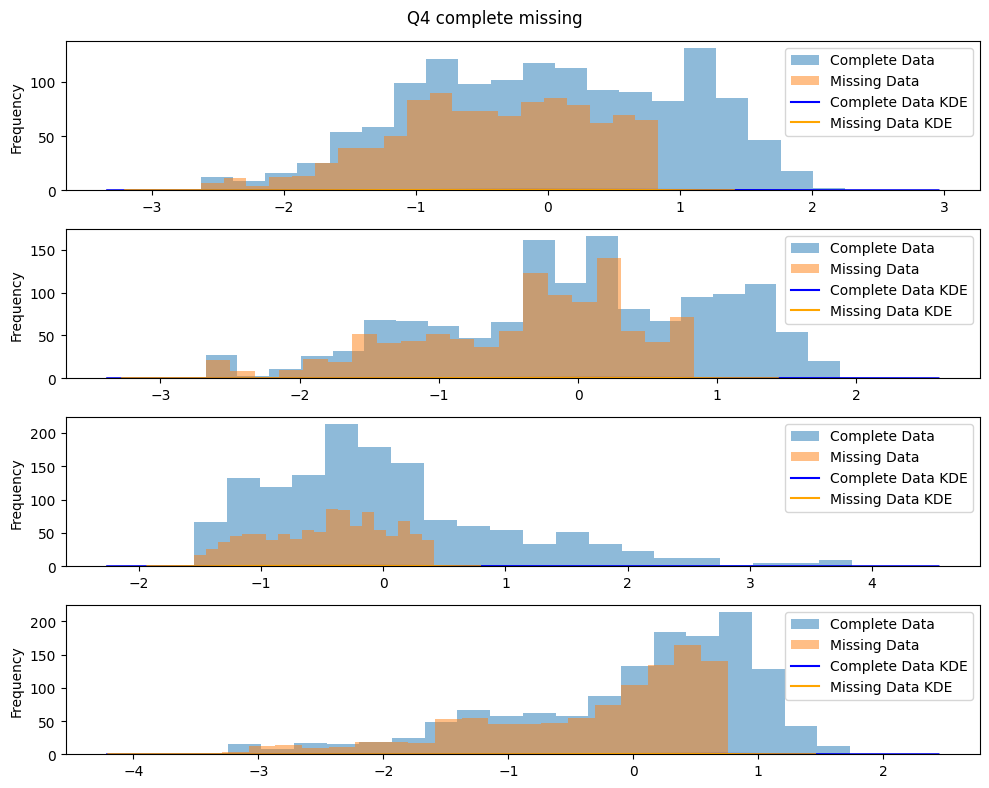

In [359]:
Xnan, Xz = missing_by_range(Xtrain, multiple_blocks["Q4_complete"])
#compare_distributions(Xtrain, Xnan,"test", False)

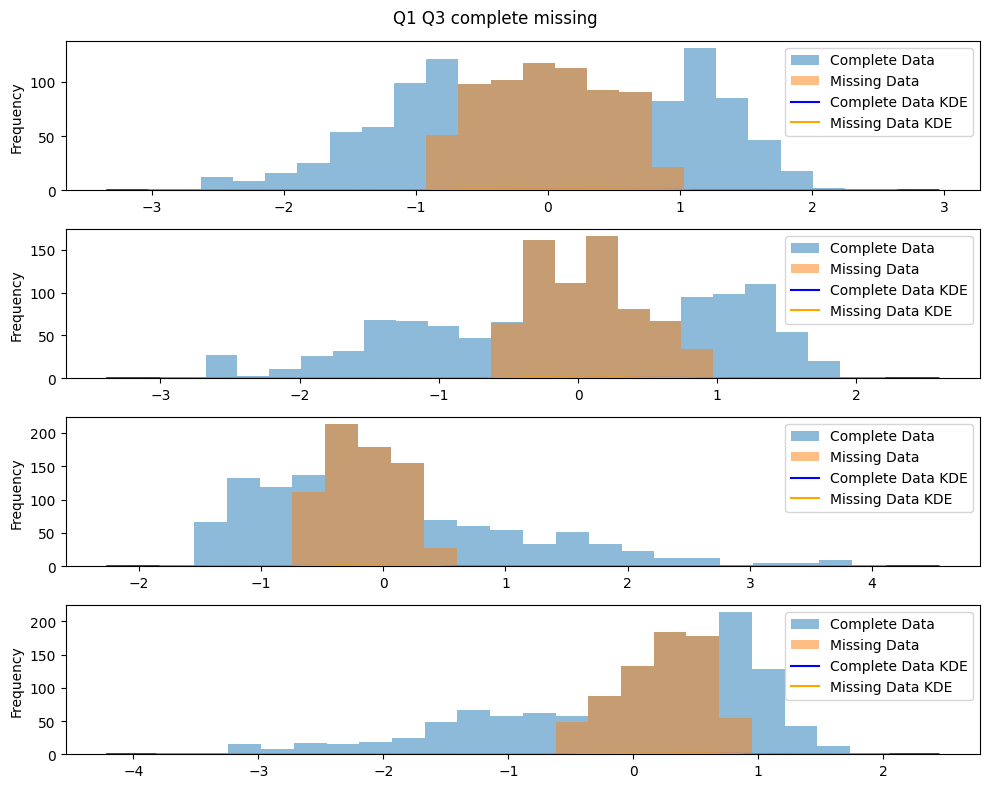

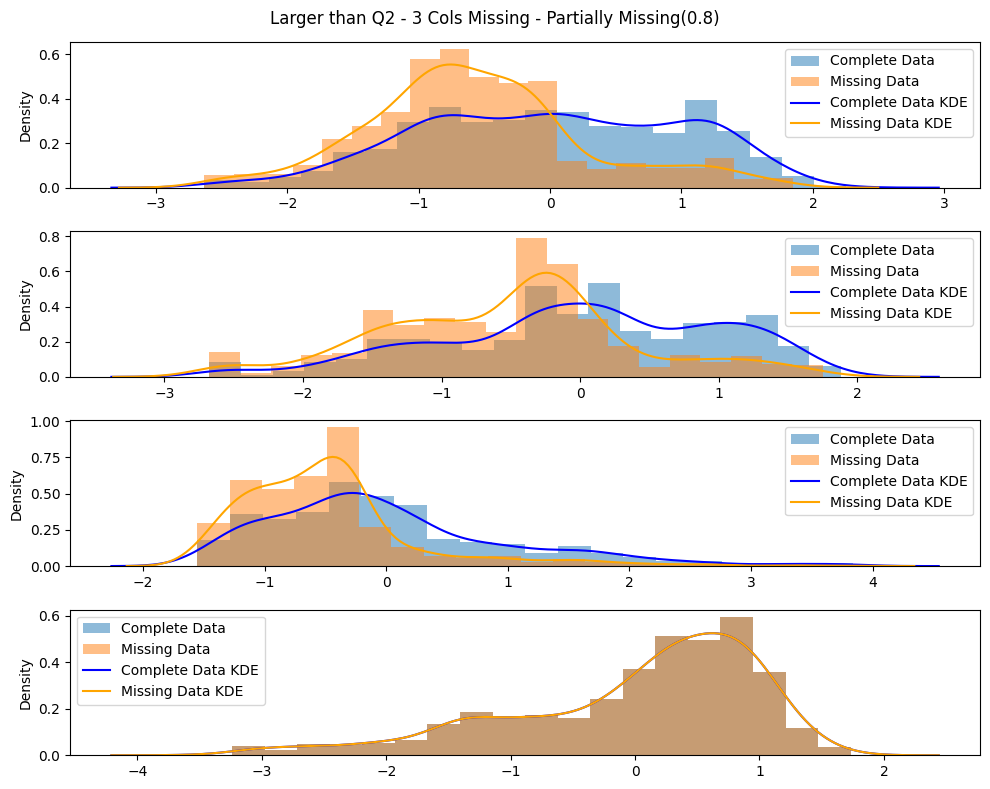

In [129]:
def compare_distributions(complete_data, missing_data,title,density = True
                          ,bins=20
                          ):
    """
    Plots histograms and kernel density estimates for each dimension of a complete dataset and a dataset with missing data.
    
    Parameters:
        complete_data (np.ndarray): A complete dataset with an arbitrary number of dimensions.
        missing_data (np.ndarray): A dataset with missing data. Must have the same shape as `complete_data`.
        bins (int): The number of bins to use for the histograms.
    
    Returns:
        None
    """
    num_dims = complete_data.shape[1]
    fig, axs = plt.subplots(nrows=num_dims, ncols=1, figsize=(10, 2*num_dims))
    plt.suptitle(title)

    for i in range(num_dims):
        axs[i].hist(complete_data[:, i], alpha=0.5, 
                    bins=bins, 
                    density=density, label='Complete Data')
        axs[i].hist(missing_data[:, i], alpha=0.5, 
                    bins=bins, 
                    density=density, label='Missing Data')
        sns.kdeplot(complete_data[:, i], ax=axs[i], color='blue', label='Complete Data KDE')
        sns.kdeplot(missing_data[:, i], ax=axs[i], color='orange', label='Missing Data KDE')
        #axs[i].set_xlabel(f'Dimension {i+1}')
        if not density:
            axs[i].set_ylabel('Frequency')
        else:
            axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.tight_layout()
    plt.savefig("plots/{}.png".format(title))
    plt.show()